### Run in collab
<a href="https://colab.research.google.com/github/racousin/data_science_practice/blob/master/website/public/modules/module13/exercise/module13_exercise1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install swig==4.2.1
!apt-get install xvfb
!pip install box2d-py==2.3.8
!pip install gymnasium[box2d,atari,accept-rom-license]==0.29.1
!pip install pyvirtualdisplay==3.0
!pip install opencv-python-headless
!pip install imageio imageio-ffmpeg
!git clone https://github.com/racousin/rl_introduction.git > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# module13_exercise1 : Q Learning

### Objective
Implement and train a Q-Learning agent to interact with and learn from the 'FrozenLake-v1' environment without a known model.

### Experiment Setup: Evaluate and Train Your Agent

`run_experiment_episode_train` is the core function you will use for agent-environment interaction and learning:

In [22]:
env = gym.make('FrozenLake-v1', is_slippery=False)

def run_experiment_episode_train(env, agent, nb_episode, is_train=True):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()[0]
        terminated, truncated = False, False
        rews = []
        while not (terminated or truncated):
            action = agent.act(state)
            current_state = state
            state, reward, terminated, truncated, info = env.step(action)
            if is_train:
                agent.train(current_state, action, reward, state, terminated or truncated)
            rews.append(reward)
        rewards[i] = sum(rews)
        #print(f'Episode: {i} - Cumulative Reward: {rewards[i]}')
    return rewards


In [4]:
class Agent:
    def __init__(self, env):
        self.env = env
    def act(self, state):
        action = env.action_space.sample()
        return action
    def train(self, current_state, action, reward, state, done):
        pass

In [5]:
demo_agent = Agent(env)
run_experiment_episode_train(env, demo_agent, nb_episode=10, is_train=True)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

**Exercise 1:** Initialize Q-Learning Agent

**Task 1a:** Initialize the `Agent` class with a Q-table filled with random values. The Q-table should have dimensions corresponding to the environment's state and action space sizes.

**Task 1b:** Create a function, `get_epsilon_greedy_action_from_Q_s`, that chooses an action based on an epsilon-greedy strategy or the argmax of Q for the current state.

**Task 1c:** Update the Agent class's act function to utilize `get_epsilon_greedy_action_from_Q_s` for action selection.

**Task 1d:** Implement the Q-learning update formula in the Agent class's train method.

$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

**Exercise 2:** Train and Evaluate the Agent

**Task 2a:** Run 100 training episodes with the Q-learning agent and collect the rewards.

**Task 2b:** Plot the cumulative reward for each training episode.

**Question 1:**

How can we improve the convergence of our Q-learning agent? Suggestion: add a epsilon_decay_exponential in the train method.

In [6]:
#TODO: get epsilon greedy policy
def get_epislon_greedy_action_from_q(Q_s, epsilon):
    if np.random.rand() > epsilon:
        return np.argmax(Q_s)
    else:
        return np.random.randint(len(Q_s))

In [7]:
#TODO: write Q learning update
class Agent():
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = np.ones((env.observation_space.n, env.action_space.n))

    def act(self, state):
        action = get_epislon_greedy_action_from_q(self.q[state], self.epsilon)
        return action

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + self.gamma * np.max(self.q[next_state])
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)

In [23]:
q_agent = Agent(env)
rewards = run_experiment_episode_train(env, q_agent, 1000)

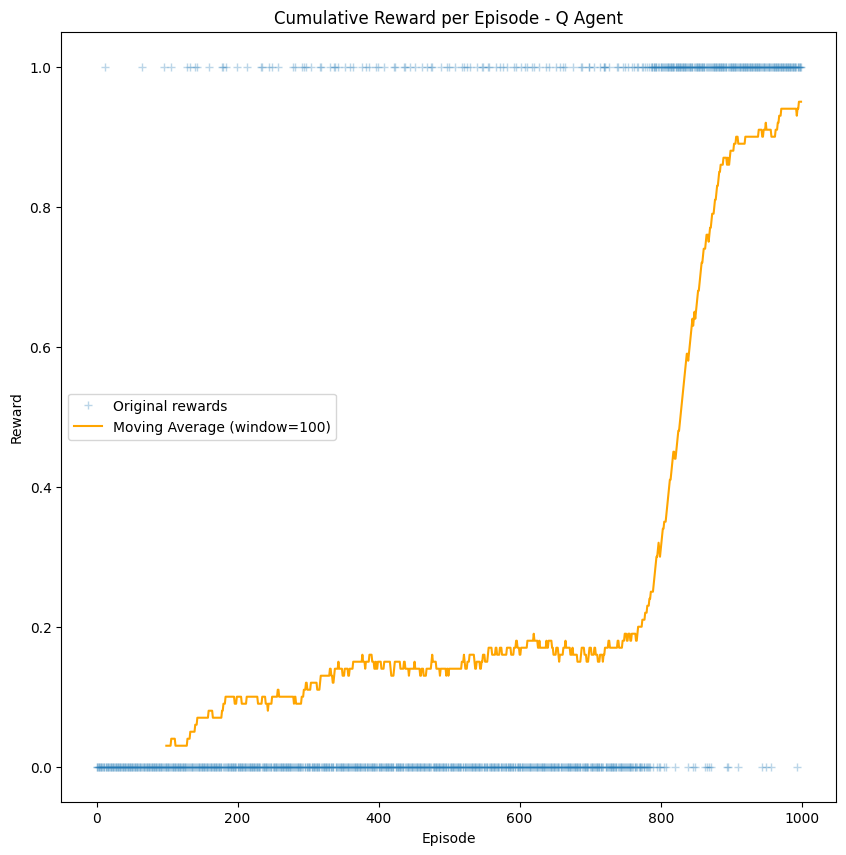

In [24]:
window_size = 100
moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')

# Plot the results
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(rewards, '+', alpha=0.3, label='Original rewards')
ax.plot(range(window_size-1, len(rewards)), moving_avg, label=f'Moving Average (window={window_size})', color='orange')
ax.set_title('Cumulative Reward per Episode - Q Agent')
ax.set_xlabel('Episode')
ax.set_ylabel('Reward')
ax.legend()

plt.show()

In [25]:
#TODO: write Q learning update
class DecayAgent():
    # Same other method as Agent
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.alpha = alpha
        self.q = np.ones((env.observation_space.n, env.action_space.n))

    def act(self, state):
        state = state if isinstance(state, int) else state[0]
        action = get_epislon_greedy_action_from_q(self.q[state], self.epsilon)
        return action

    def qsa_update(self, state, action, reward, next_state, done):
        target = reward + self.gamma * np.max(self.q[next_state])
        td_error = target - self.q[state, action]
        self.q[state, action] += self.alpha * td_error

    # Modification par rapport à Agent
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        self.epsilon_decay_exponential()

    def epsilon_decay_exponential(self):
        self.epsilon = max(self.epsilon * 0.9, 0.01)

In [26]:
# Initialize agents with random and optimal policies
decay_agent = DecayAgent(env)
agent = Agent(env)

# Run experiments for each agent
rewards_decay_agent = run_experiment_episode_train(env, decay_agent, 1000)
rewards_agent = run_experiment_episode_train(env, agent, 1000)


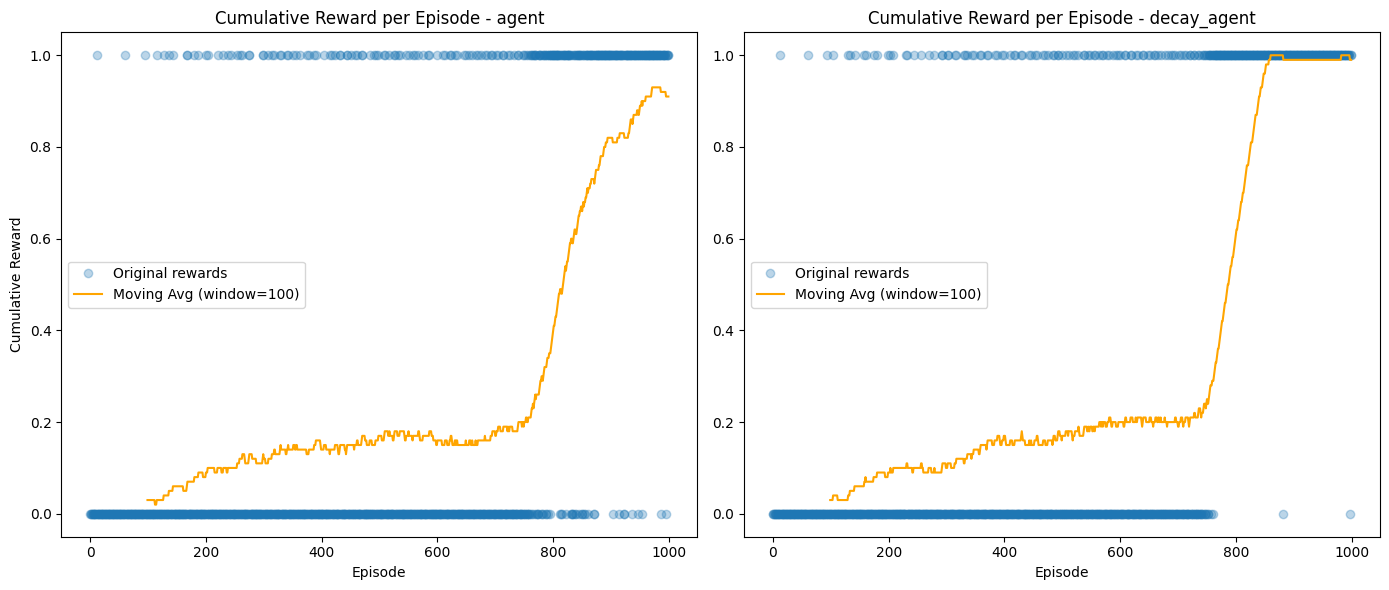

In [27]:
# Compute the moving average with a window size of 100
window_size = 100
moving_avg = np.convolve(rewards_agent, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay = np.convolve(rewards_decay_agent, np.ones(window_size) / window_size, mode='valid')

# Plot with subplots
plt.figure(figsize=(14, 6))

# First subplot: Original rewards with moving average for agent
plt.subplot(1, 2, 1)
plt.plot(rewards_agent, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_agent)), moving_avg, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

# Second subplot: Original rewards with moving average for decay_agent
plt.subplot(1, 2, 2)
plt.plot(rewards_decay_agent, 'o', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_decay_agent)), moving_avg_decay, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - decay_agent')
plt.xlabel('Episode')
plt.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()


In [13]:
# Watch your agent play
from rl_introduction.rl_introduction.render_colab import exp_render

exp_render({"name":'FrozenLake-v1', "fps":2, "nb_step":10, "agent": decay_agent})

/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# creat/train/test your agent in other discrete action-space env

In [28]:
#env = gym.make('Blackjack-v1')
env = gym.make('Taxi-v3')

In [29]:
your_agent = Agent(env)
your_decay_agent = DecayAgent(env)

nb_episode = 5000

rewards_my_agent = run_experiment_episode_train(env, your_agent, nb_episode, is_train=True)
rewards_my_decay_agent = run_experiment_episode_train(env, your_decay_agent, nb_episode, is_train=True)

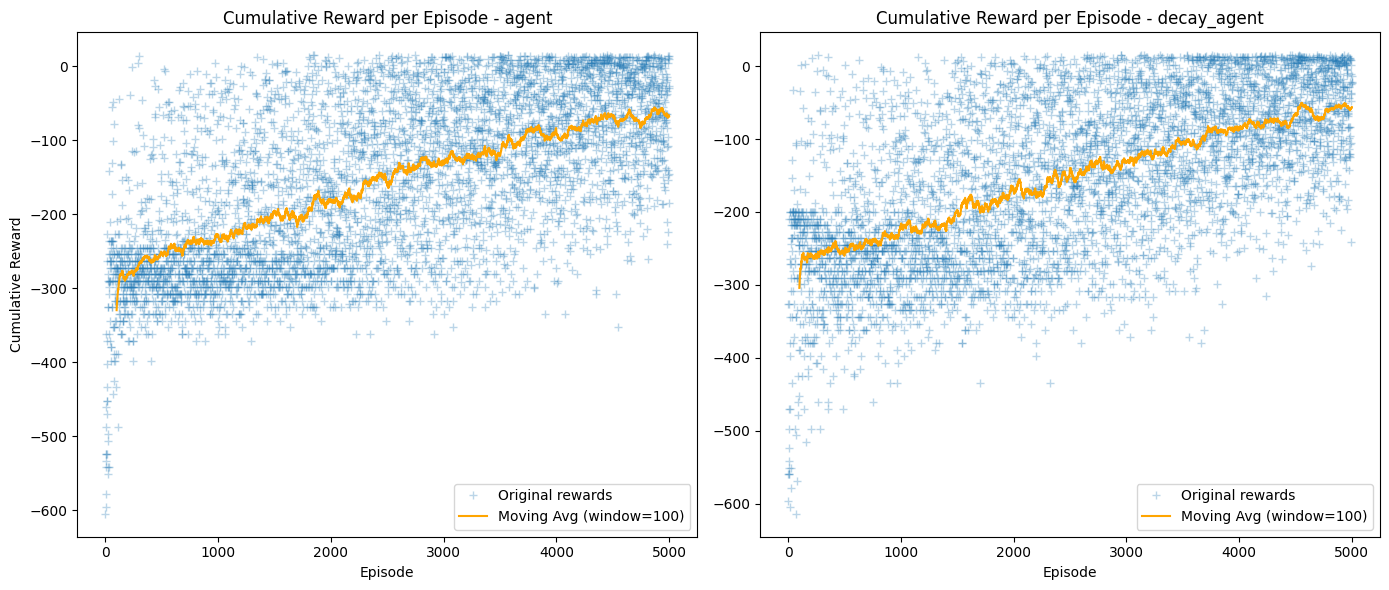

In [31]:
# Compute the moving average with a window size of 100
window_size = 100
moving_avg = np.convolve(rewards_my_agent, np.ones(window_size) / window_size, mode='valid')
moving_avg_decay = np.convolve(rewards_my_decay_agent, np.ones(window_size) / window_size, mode='valid')

# Plot with subplots
plt.figure(figsize=(14, 6))

# First subplot: Original rewards with moving average for agent
plt.subplot(1, 2, 1)
plt.plot(rewards_my_agent, '+', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_my_agent)), moving_avg, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - agent')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()

# Second subplot: Original rewards with moving average for decay_agent
plt.subplot(1, 2, 2)
plt.plot(rewards_my_decay_agent, '+', alpha=0.3, label='Original rewards')
plt.plot(range(window_size - 1, len(rewards_my_decay_agent)), moving_avg_decay, label=f'Moving Avg (window={window_size})', color='orange')
plt.title('Cumulative Reward per Episode - decay_agent')
plt.xlabel('Episode')
plt.legend()

# Adjust layout and show
plt.tight_layout()
plt.show()


In [17]:
exp_render({"name":'Taxi-v3', "fps":2, "nb_step":20, "agent": your_agent})

Visualisation des courbes d'apprentissage

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


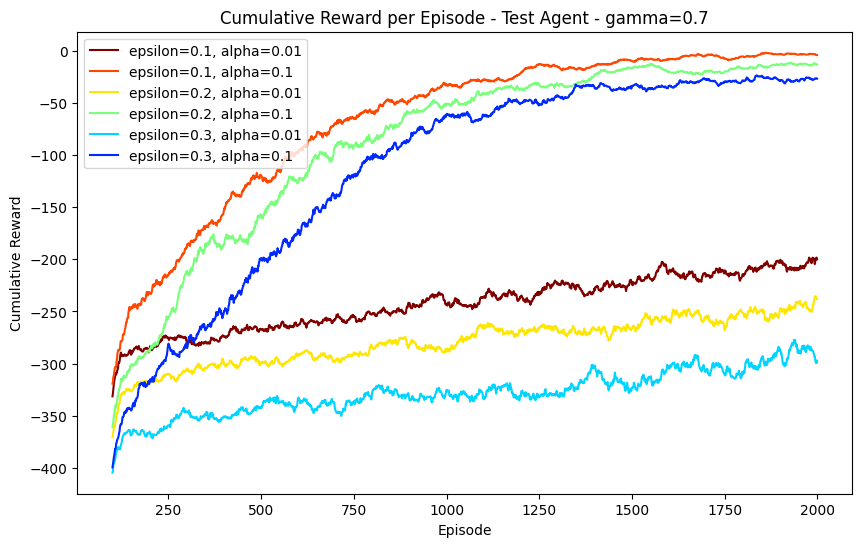

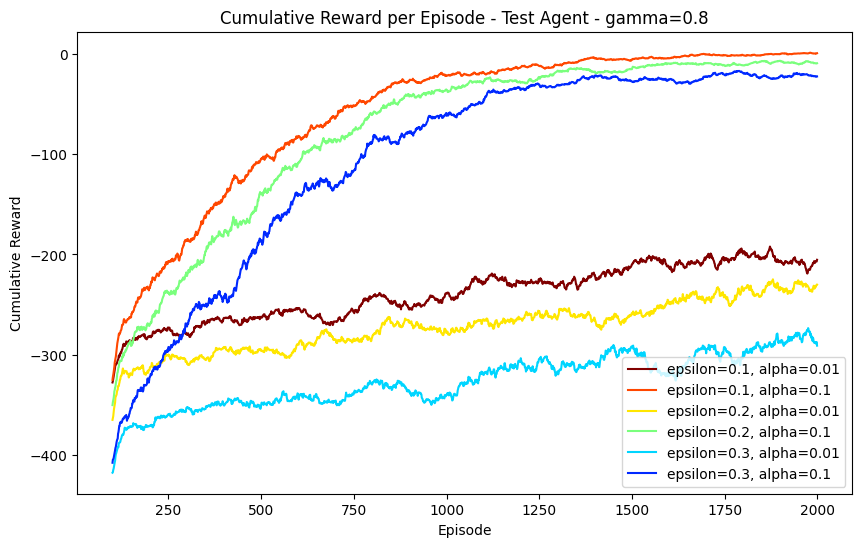

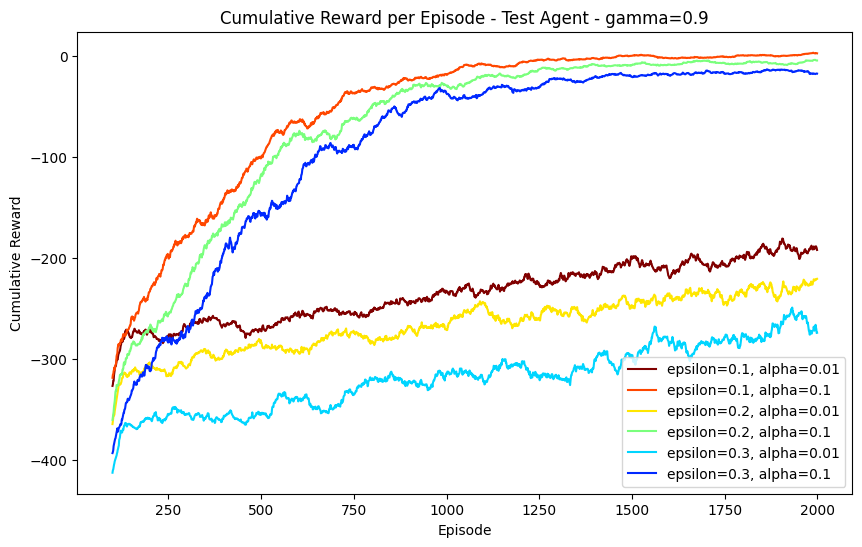

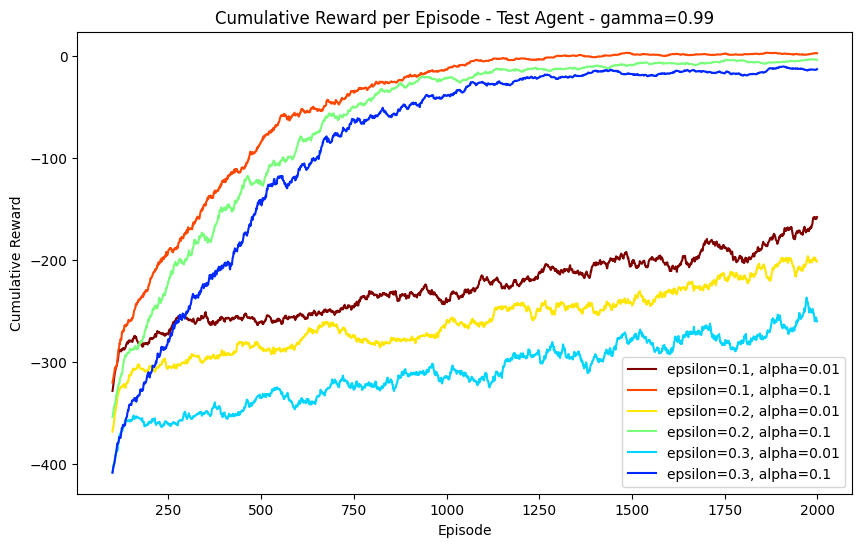

In [18]:
env = gym.make('Taxi-v3')

gammas = [.7, .8, .9, .99]
epsilons = [.1, .2, .3]
alphas = [.01, .1]

nb_episode = 2000

N=6
cmap = plt.get_cmap('jet_r')

for gamma in gammas:
    plt.figure(figsize=(10, 6))
    i=0

    for epsilon in epsilons:
        for alpha in alphas:
            test_agent = Agent(env, gamma, epsilon, alpha)
            rewards_test_agent = run_experiment_episode_train(env, test_agent, nb_episode, is_train=True)
            window_size = 100
            moving_avg = np.convolve(rewards_test_agent, np.ones(window_size) / window_size, mode='valid')
            color = cmap(float(i)/N)
            i +=1
            plt.plot(range(window_size - 1, len(rewards_test_agent)), moving_avg, label=f'epsilon={epsilon}, alpha={alpha}', color=color)

    plt.title(f'Cumulative Reward per Episode - Test Agent - gamma={gamma}')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.legend()
    plt.show()

On voit avec les graph que alpha = 0.1 donne une convergence plus rapide que alpha = 0.01

Il semble de même avec un gamma plus proche de 1.

En conidérant la courbe rouge vif (epsilon=0.1, alpha=0.1), observons plus précisément les écarts selon les gammas :

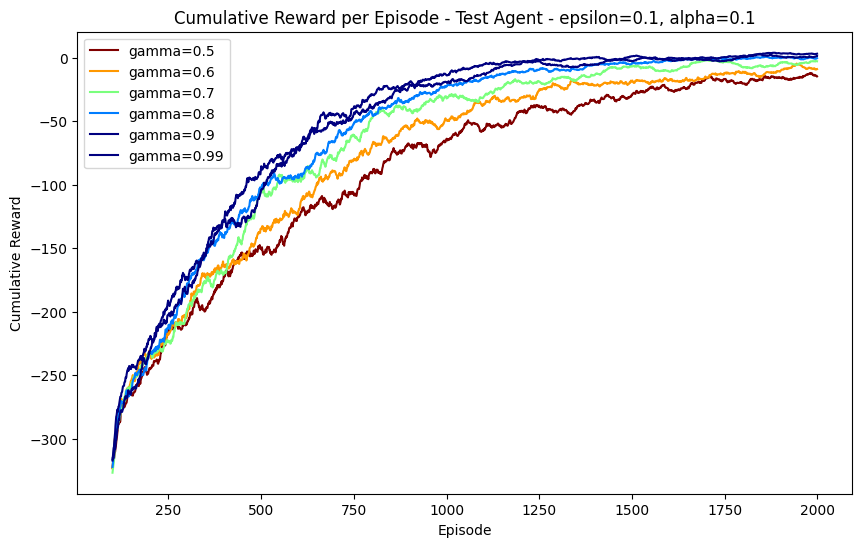

In [19]:
plt.figure(figsize=(10, 6))
i=0
N=4

gammas = [.5, .6, .7, .8, .9, .99]

for gamma in gammas:
    test_agent = Agent(env, gamma, 0.1, 0.1)
    rewards_test_agent = run_experiment_episode_train(env, test_agent, nb_episode, is_train=True)
    window_size = 100
    moving_avg = np.convolve(rewards_test_agent, np.ones(window_size) / window_size, mode='valid')
    color = cmap(float(i)/N)
    i +=1
    plt.plot(range(window_size - 1, len(rewards_test_agent)), moving_avg, label=f'gamma={gamma}', color=color)

plt.title(f'Cumulative Reward per Episode - Test Agent - epsilon=0.1, alpha=0.1')
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.legend()